In [2]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
from scipy.fft import fft
from scipy import signal as signal

In [3]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the hanning window
  window = signal.get_window('hann', sound_array.size)
  # compute the spectrum of the windowed input signal
  spectrum = fft(window*sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/spectrum.size)
  plt.plot(frequency_indexes, magnitude_spectrum)
  plt.xlabel('frequency (Hz)')
  plt.ylabel('amplitude (dB)')
  plt.show()

def display_spectrogram(sound_array, hop_size=256, fft_size=512, sampling_rate=44100):
  """ Display magnitude spectrogram of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      hop_size (int): window hop size
      fft_size (int): Spectrogram fft size
      sampling_rate (int): Sampling rate of sound
  """
  # compute the hanning window
  window = signal.get_window('hann', fft_size)
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(window*sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += hop_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  time_indexes = np.arange(0, sample_index/sampling_rate, hop_size/sampling_rate)
  frequency_indexes = np.arange(0, sampling_rate/2, sampling_rate/fft_size)
  plt.pcolormesh(time_indexes, frequency_indexes, np.transpose(magnitude_spectrogram), shading='nearest', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('time (seconds)')
  plt.ylabel('frequency (Hz)')
  plt.show()

def plot_freq_response(w, h, title):
  "Utility function to plot frequency response functions"
  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111)
  ax.plot(w, 20*np.log10(np.abs(h)))
  ax.set_ylim(-80, 5)
  ax.grid(True)
  ax.set_xlabel('Frequency (Hz)')
  ax.set_ylabel('Gain (dB)')
  ax.set_title(title)

def prototype_filter(N, L):
  """ Generate a prototype FIR low-pass filter using a window method.
    Args:
      N (int): length of filter
      L (int): number of subbands
    Returns:
      Coefficients of the resulting FIR filter
  """
  return signal.firwin(N, 1.0 / (2 * L), window='hamming')

def modulate_filter(h, M, k):
    # Modulate the prototype filter
    n = np.arange(len(h))
    modulation = 2 * np.cos(np.pi * (2 * k + 1) * (n - (len(h) - 1) / 2) / (2 * M))
    return h * modulation

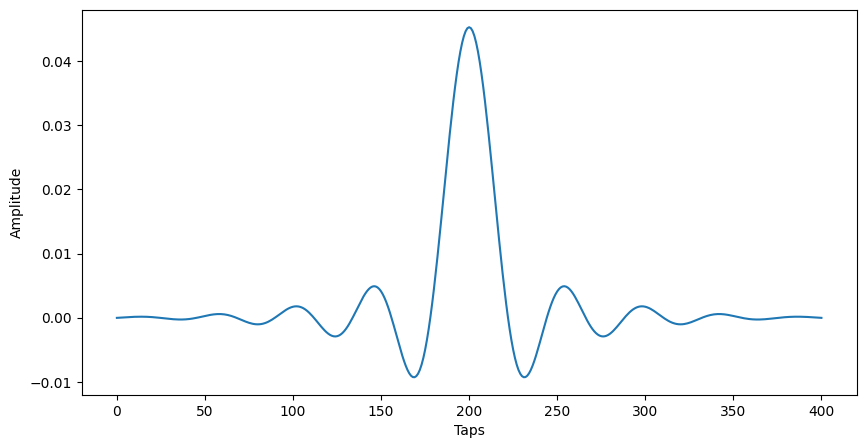

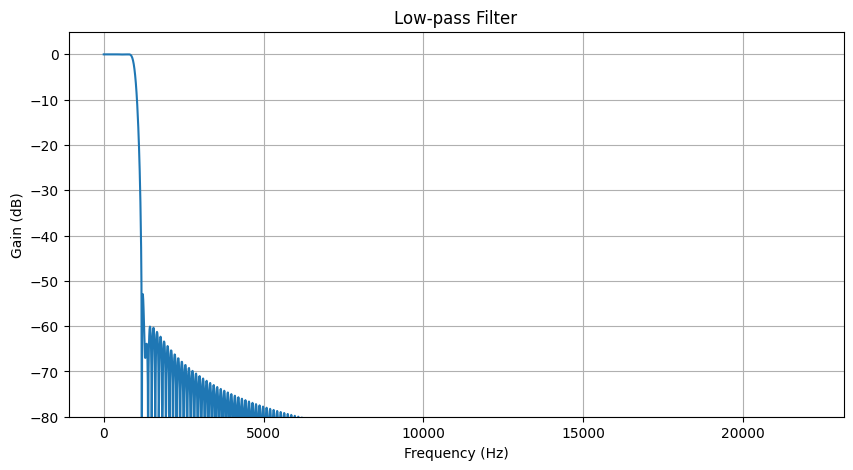

In [4]:
# design a low pass filter
fs = 44100.0
filter_length = 401
cutoff = 1000
h = signal.firwin(filter_length, cutoff, window='hamming', fs=fs)

# plot impulse response of filter
plt.figure(figsize=(10, 5))
plt.plot(h)
plt.xlabel('Taps')
plt.ylabel('Amplitude')
plt.show()

# plot frequency response of filter
w, H = signal.freqz(h, [1], worN=2000, fs=fs)
plot_freq_response(w, H, "Low-pass Filter")
plt.show()

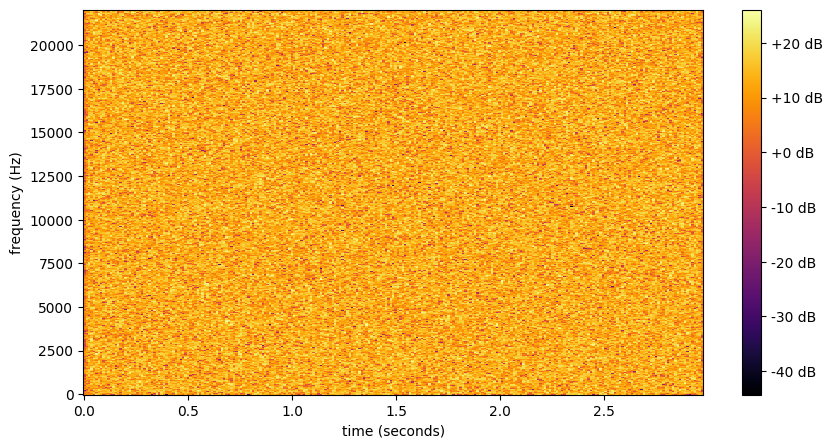

In [5]:
# filter a sound with the lowpass filter
sound_array, sampling_rate = read_sound('../sounds/white-noise.wav')
# apply filter by convolving the sound with the impulse response of filter
filtered_sound = signal.lfilter(h, 1, sound_array)
# display original sound
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
display_spectrogram(sound_array, 512, 1024, sampling_rate)
# display filtered sound
ipd.display(ipd.Audio(data=filtered_sound, rate=sampling_rate))
display_spectrogram(filtered_sound, 512, 1024, sampling_rate)

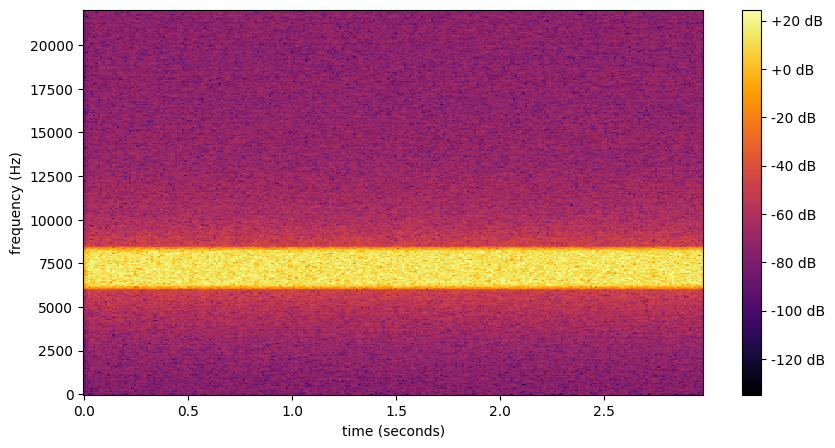

In [6]:
#select one filter band
k = 10
L = 32
hk = modulate_filter(h, L, k)
# Filter the signal
y = signal.lfilter(hk, 1, sound_array)
# display filtered sound
ipd.display(ipd.Audio(data=y, rate=sampling_rate))
display_spectrogram(y, 512, 1024, sampling_rate)

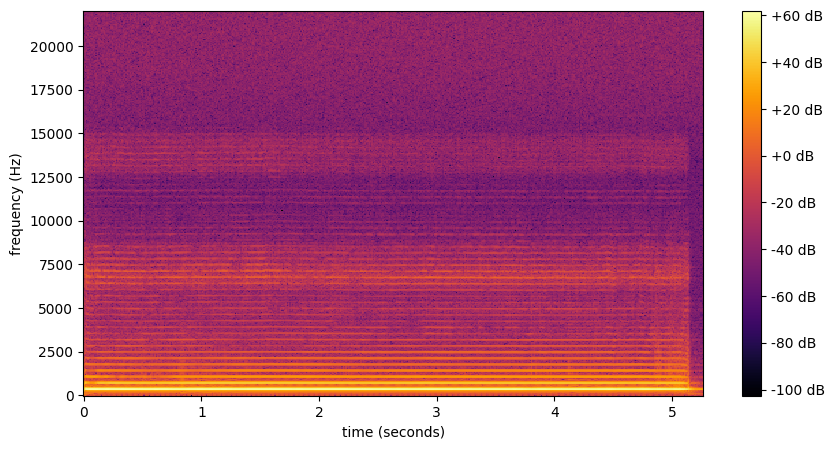

In [12]:
# apply the whole filter bank to a sound

sound_array, sampling_rate = read_sound('../sounds/406609-tuba.wav')

# design a low pass filter
N = 21
L = 32
h = prototype_filter(N, L)


y = np.zeros(len(sound_array))

for k in range(L):
  # Modulate prototype filter
  hk = modulate_filter(h, L, k)
  # Filter the signal
  filtered_sound = signal.lfilter(hk, 1, sound_array)
  y += filtered_sound

# display original sound
ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))
display_spectrogram(sound_array, 512, 1024, sampling_rate)

# display filtered sound
ipd.display(ipd.Audio(data=y, rate=sampling_rate))
display_spectrogram(y, 512, 1024, sampling_rate)